# Segundo modelo

Regresión lineal utilizando como predictores los datos propios del Índice IBEX 35 y los 10 componentes más importantes que pertenecen a este índice (AENA, AMS, BBVA, CABK, FER, IBE, ITX, REP, SAN, TEF). Este índice integra las cotizaciones de las 35 empresas más importantes de España. Es un índice ponderado según la capitalización bursatil de las 35 empresas que lo componen; es decir, las empresas que tienen una mayor capitalización tiene más peso en el índice.
El dataset con el que trabajaremos dispone de las siguientes variables:
- fecha, día de la muestra
- último, valor de cierre del índice IBEX 35 expresado en puntos para ese día (unidad puntos)
- deuda_publica, conjunto de deudas que mantiene el Estado español frente a los particulares que pueden ser españoles o de otro país
- ipc, indicador que mide la variación de los precios de una cesta de bienes y servicios en un lugar concreto durante un determinado periodo de tiempo
- tasa_paro, mide el nivel de desocupación en relación con la población activa
- pib, suma de todos los bienes y servicios finales que produce un país o una economía, elaborados dentro del territorio nacional tanto por empresas nacionales como extranjeras, y que se registran en un periodo determinado
- COMPONENTE_ultimo, valor de cierre del componente expresado en puntos para ese día (unidad puntos)
- COMPONENTE_per, relación precio-beneficio para ese componente
- COMPONENTE_bpa, beneficio por acción para ese componente
- COMPONENTE_rentabilidad_por_dividendo, para ese componente
- COMPONENTE_precio_valor_contable, para ese componente
- COMPONENTE_ebitda, para ese componente

La variable a predecir:  
- el valor último o de cierre

En esta primera prueba vamos a utilizar el dataset con los datos desde el 12-02-2015. Se filtra por esta fecha porque viene marcado por el dataset de AENA que sólo tiene datos desde esa fecha. Además las variables predictoras que utilizamos no tienen datos desde el año 1991.

## Carga de las librerías y datos

In [1]:
import numpy as np
import pandas as pd
import pandas as pdBb
import glob
import datetime
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.externals import joblib
import statsmodels.api as sm
from sklearn import metrics

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Definimos tres funciones:
- get_all_historic_data(): retorna el histórico de datos existentes en el directorio /dataset/NOMBRE_INDICE/final_historic_data_with_metrics_NOMBRE_INDICE_[all / filter_by_20150212].csv. Dependiendo de si tiene activo el filtro filter_year retornará todos los datos o únicamente los existentes a partir del 12-02-2015. Estos dataset se generan de forma automática en el script 01_Generate_historic_data.py.
El método recibe como parámetros el nombre del índice y el flag que indica que datos desea obtener y retorna un dataframe.
- transform_data(): realiza una serie de transformaciones sobre el dataframe de entrada. Recibe como parámetro de entrada un dataframe y retorna el mismo dataframe con las transformaciones necesarias.
- fill_pending_dates(): se encarga de añadir todas las fechas no presentes en el dataset. Recibe como parámetros de entrada un dataframe y el tipo de frecuencia deseada para la serie temporal.

In [2]:
def get_all_historic_data(name_index, filter_year):
    # Cargamos todo el histórico de datos que tenemos de IBEX35
    if(filter_year==False):
        filename = './dataset/' + name_index + '/final_historic_data_with_metrics_' + name_index + '_all.csv'
    else:
        filename = './dataset/' + name_index + '/final_historic_data_with_metrics_' + name_index + '_filter_by_20150212_copia.csv'
    final_historic_data = pd.read_csv(filename)
    
    # Añadimos el resto de predictores de los 10 componentes más importantes del IBEX35
    components = ['AENA','AMS','BBVA','CABK','FER','IBE','ITX','REP','SAN','TEF']
    for item in components:
        file = './dataset/' + item + '/final_historic_data_with_metrics_' + item + '_filter_by_20150212.csv'
        data_item = pd.read_csv(file, index_col=None, sep=",")
        final_historic_data = final_historic_data.merge(data_item, on="fecha", how="left")
    
    # Aplicamos las transformaciones que nos hacen falta
    # Cambiamos el valor "-" de la columna vol a NaN
    final_historic_data["vol"] = final_historic_data["vol"].replace("-", np.NaN)
    # Necesitamos convertir la columna Fecha a Date
    final_historic_data['fecha'] =  pd.to_datetime(final_historic_data['fecha'], format = "%Y-%m-%d", errors ='coerce')
    # Ordenamos los registros por la fecha
    final_historic_data.sort_values(by=('fecha'),ascending=True)
    
    columns = final_historic_data.columns.values.tolist()
    data_total = pd.DataFrame(final_historic_data, columns=columns)
    return data_total

# Función que aplica las transformaciones en el volumen
def convert_cash(item):
    transform = {'B': 10**3, 'M': 1}
    try:
        item_transform = item[-1]
        return float(item[:-1]) * transform[item_transform]
    except TypeError:
        return item
    
# Función que aplica una serie de transformaciones al dataset
def transform_data(data, columns_drop, colums_type):
    # Cambiamos el formato de miles y decimales de todas las columnas
    data = data.replace(r'[.]','', regex=True)
    data = data.replace(r'[,]','.', regex=True)
    data = data.replace('- ','-', regex=True)
    # Quitamos las columnas que vengan indicadas en el parámetro columns_drop
    data = data.drop(columns_drop, axis=1)
    if 'vol' in data.columns:
        # Volumen: existen dos tipos de unidades (M millones) y (B billones)
        # Se harán dos transformaciones:
        # - (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
        # - (B billones) vamos a quitar la unidad y multiplicamos por 1000
        data['vol'] = data['vol'].map(lambda x: convert_cash(x) if (pd.notnull(x)) else x)   
    if 'variacion' in data.columns:
        # Variación: vamos a quitar el % aunque no haremos la transformación en los datos 
        data['variacion'] = data['variacion'].map(lambda x: x.rstrip('%') if (pd.notnull(x)) else x)
    # Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
    # adelante siempre que se encuentren valores nulos en las columnas: deuda_publica, ipc, tasa_paro y pib
    if 'deuda_publica' in data.columns:
        data['deuda_publica'].fillna(method='ffill', inplace=True)
    if 'ipc' in data.columns:
        data['ipc'].fillna(method='ffill', inplace=True)
    if 'tasa_paro' in data.columns:
        data['tasa_paro'].fillna(method='ffill', inplace=True)
    if 'pib' in data.columns:
        data['pib'].fillna(method='ffill', inplace=True)
    # Convertimos los NaN a 0
    data = data.fillna(0)
    # Convertimos las columnas a los formatos indicados en el parámetro columns_type
    data = data.astype(colums_type)
    # Ordenamos el dataset por fecha en orden ascendente
    data = data.sort_values(by=["fecha"])
    # Ponemos la columna date como índice
    data.set_index("fecha", inplace=True)
    # Ordenamos los índices
    data.sort_index(inplace=True)
    return data

# Función que rellena todas las fechas que faltan en el dataset
def fill_pending_dates(data, type_freq):
    ref_date_range = pd.date_range(start = data.index.min(), end = data.index.max(), freq=type_freq)
    data = data.reindex(ref_date_range)
    return data

## Análisis exploratorio de los datos (EDA)

Llamamos a la función para obtener el histórico de datos del índice IBEX35 y mostramos el total de elementos.

In [3]:
data_total = get_all_historic_data('IBEX35',True)
data_total.shape

(1418, 71)

Visualizamos una pequeña muestra del dataset.

In [4]:
data_total.head(-10)

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,...,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,SAN_ebitda,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
0,2015-02-13,"10.739,50","10.618,50","10.794,90","10.606,70","427,94M","1,68%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,934",NaN,NaN,NaN,NaN,NaN
1,2015-02-16,"10.689,50","10.717,80","10.793,10","10.679,90","220,58M","-0,47%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,900",NaN,NaN,NaN,NaN,NaN
2,2015-02-17,"10.698,00","10.591,60","10.730,10","10.526,60","272,47M","0,08%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,890",NaN,NaN,NaN,NaN,NaN
3,2015-02-18,"10.805,30","10.764,60","10.852,60","10.764,10","298,37M","1,00%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"12,905",NaN,NaN,NaN,NaN,NaN
4,2015-02-19,"10.910,40","10.781,00","10.918,40","10.726,30","350,26M","0,97%","1.044.720,44","-1,07","23,78",...,NaN,NaN,NaN,NaN,"13,023",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,2020-08-11,"7.263,50","7.104,00","7.290,10","7.104,00","271,63M","2,97%","1.257.818,96","-0,60","15,33",...,"0,19","5,00","0,31",0.0,"3,641","8,14","0,43","10,99","0,99",14.806
1404,2020-08-12,"7.296,00","7.250,30","7.317,90","7.225,70","219,85M","0,45%","1.257.818,96","-0,60","15,33",...,"0,19","5,03","0,31",0.0,"3,645","8,14","0,43","10,97","0,99",14.806
1405,2020-08-13,"7.250,50","7.267,90","7.321,90","7.240,80","159,77M","-0,62%","1.257.818,96","-0,60","15,33",...,"0,20","4,67","0,36","0,00","3,656","8,48","0,50","4,73","1,16","15.160,37"
1406,2020-08-14,"7.154,30","7.224,10","7.227,60","7.064,00","175,80M","-1,33%","1.257.818,96","-0,60","15,33",...,"0,20","4,67","0,36","0,00","3,631","8,48","0,50","4,73","1,16","15.160,37"


En este primer modelo de series temporales únicamente vamos a tener en cuenta para entrenar el modelo el predictor. Posteriormente realizaremos un segundo modelo utilizando las mismas variables que aplicamos en la Regresión Múltiple.
Llamamos a la función para que realice las transformaciones necesarias en el dataset y lo mostramos de forma gráfica.
Vamos a eliminar los predictores BBVA_ebitda, CABK_ebitda y SAN_ebitda porque no hay datos.

In [5]:
data_total = transform_data(data_total,['apertura','maximo','minimo','vol','variacion','BBVA_ebitda','CABK_ebitda','SAN_ebitda'], 
                    {"ultimo": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, "pib": float,
                    "AENA_ultimo":float, "AENA_per": float, "AENA_bpa": float, "AENA_rentabilidad_por_dividendo": float,
                    "AENA_precio_valor_contable": float, "AENA_ebitda": float,
                    "AMS_ultimo":float, "AMS_per": float, "AMS_bpa": float, "AMS_rentabilidad_por_dividendo": float,
                    "AMS_precio_valor_contable": float, "AMS_ebitda": float,
                    "BBVA_ultimo":float, "BBVA_per": float, "BBVA_bpa": float, "BBVA_rentabilidad_por_dividendo": float,
                    "BBVA_precio_valor_contable": float,
                    "CABK_ultimo":float, "CABK_per": float, "CABK_bpa": float, "CABK_rentabilidad_por_dividendo": float,
                    "CABK_precio_valor_contable": float,
                    "FER_ultimo":float, "FER_per": float, "FER_bpa": float, "FER_rentabilidad_por_dividendo": float,
                    "FER_precio_valor_contable": float, "FER_ebitda": float,
                    "IBE_ultimo":float, "IBE_per": float, "IBE_bpa": float, "IBE_rentabilidad_por_dividendo": float,
                    "IBE_precio_valor_contable": float, "IBE_ebitda": float,
                    "ITX_ultimo":float, "ITX_per": float, "ITX_bpa": float, "ITX_rentabilidad_por_dividendo": float,
                    "ITX_precio_valor_contable": float, "ITX_ebitda": float,
                    "REP_ultimo":float, "REP_per": float, "REP_bpa": float, "REP_rentabilidad_por_dividendo": float,
                    "REP_precio_valor_contable": float, "REP_ebitda": float,
                    "SAN_ultimo":float, "SAN_per": float, "SAN_bpa": float, "SAN_rentabilidad_por_dividendo": float,
                    "SAN_precio_valor_contable": float,
                    "TEF_ultimo":float, "TEF_per": float, "TEF_bpa": float, "TEF_rentabilidad_por_dividendo": float,
                    "TEF_precio_valor_contable": float, "TEF_ebitda": float
                   })

Deberemos validar que el dataset este completo para todas las fechas del periodo B (días laborales). Para eso realizaremos la validación que tenemos a continuación. En caso de no presentar todos los datos será necesario llamar a la función fill_pending_dates()

In [6]:
# Validamos si existen todos los índices en el dataset. En caso de existir índices pendientes será necesario llamar
# a la función fill_pending_dates()
ref_date_range = pd.date_range(start = data_total.index.min(), end = data_total.index.max(), freq='B')
ref_date_range
ref_df = pd.DataFrame(np.random.randint(1, 20, (ref_date_range.shape[0], 1)))
ref_df.index = ref_date_range
missing_dates = ref_df.index[~ref_df.index.isin(data_total.index)]
missing_dates

DatetimeIndex(['2015-04-03', '2015-04-06', '2015-05-01', '2015-12-25',
               '2016-01-01', '2016-03-25', '2016-03-28', '2016-12-26',
               '2017-04-14', '2017-04-17', '2017-05-01', '2017-12-25',
               '2017-12-26', '2018-01-01', '2018-03-30', '2018-04-02',
               '2018-05-01', '2018-12-25', '2018-12-26', '2019-01-01',
               '2019-04-19', '2019-04-22', '2019-05-01', '2019-12-25',
               '2019-12-26', '2020-01-01', '2020-04-10', '2020-04-13',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', freq=None)

In [7]:
data_total = fill_pending_dates(data_total, "B")
data_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2015-02-13 to 2020-08-31
Freq: B
Data columns (total 62 columns):
ultimo                             1417 non-null float64
deuda_publica                      1417 non-null float64
ipc                                1417 non-null float64
tasa_paro                          1417 non-null float64
pib                                1417 non-null float64
AENA_ultimo                        1417 non-null float64
AENA_per                           1417 non-null float64
AENA_bpa                           1417 non-null float64
AENA_rentabilidad_por_dividendo    1417 non-null float64
AENA_precio_valor_contable         1417 non-null float64
AENA_ebitda                        1417 non-null float64
AMS_ultimo                         1417 non-null float64
AMS_per                            1417 non-null float64
AMS_bpa                            1417 non-null float64
AMS_rentabilidad_por_dividendo     1417 non-null float64
AMS_precio_v

In [8]:
data_total.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib,AENA_ultimo,AENA_per,AENA_bpa,AENA_rentabilidad_por_dividendo,AENA_precio_valor_contable,...,SAN_per,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15,74.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.934,0.0,0.0,0.0,0.0,0.0
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15,72.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.900,0.0,0.0,0.0,0.0,0.0
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15,74.90,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.890,0.0,0.0,0.0,0.0,0.0
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15,76.87,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.905,0.0,0.0,0.0,0.0,0.0
2015-02-19,10910.4,1044720.44,-1.07,23.78,1.15,77.15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.023,0.0,0.0,0.0,0.0,0.0


Vamos a acceder al índice de un missing date para ver que efectivamente se han agregado correctamente. Por defecto veremos que el valor añadido es NaN; en este caso, para que no interfiera en el modelo hemos decidido que se rellene con el valor "ultimo" de la fecha anterior.

In [9]:
# Valor previo al missing value
data_total.loc['2017-04-13']

ultimo                              10326.10
deuda_publica                     1114486.83
ipc                                     2.55
tasa_paro                              17.22
pib                                     1.02
                                     ...    
TEF_per                                 5.62
TEF_bpa                                 0.75
TEF_rentabilidad_por_dividendo          5.73
TEF_precio_valor_contable               1.21
TEF_ebitda                          16365.95
Name: 2017-04-13 00:00:00, Length: 62, dtype: float64

In [10]:
# Valor del missing value
data_total.loc['2017-04-14']

ultimo                           NaN
deuda_publica                    NaN
ipc                              NaN
tasa_paro                        NaN
pib                              NaN
                                  ..
TEF_per                          NaN
TEF_bpa                          NaN
TEF_rentabilidad_por_dividendo   NaN
TEF_precio_valor_contable        NaN
TEF_ebitda                       NaN
Name: 2017-04-14 00:00:00, Length: 62, dtype: float64

In [11]:
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos.
data_total.fillna(method='ffill', inplace=True)

In [12]:
# Validamos que ha tomado el valor correcto
data_total.loc['2017-04-14']

ultimo                              10326.10
deuda_publica                     1114486.83
ipc                                     2.55
tasa_paro                              17.22
pib                                     1.02
                                     ...    
TEF_per                                 5.62
TEF_bpa                                 0.75
TEF_rentabilidad_por_dividendo          5.73
TEF_precio_valor_contable               1.21
TEF_ebitda                          16365.95
Name: 2017-04-14 00:00:00, Length: 62, dtype: float64

In [13]:
# Y no existan más nulos
data_total['ultimo'].isnull().sum()

0

En nuestra caso la serie temporal tiene un periodo B (días laborales); establecemos dicho periodo y mostramos la información de forma gráfica.

In [14]:
# Establecemos el periodo B (business day frequency) de Lúnes a Viernes
data_total = data_total.to_period("B")
# Existen periodos de muchos tipos
data_total.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib,AENA_ultimo,AENA_per,AENA_bpa,AENA_rentabilidad_por_dividendo,AENA_precio_valor_contable,...,SAN_per,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15,74.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.934,0.0,0.0,0.0,0.0,0.0
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15,72.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.900,0.0,0.0,0.0,0.0,0.0
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15,74.90,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.890,0.0,0.0,0.0,0.0,0.0
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15,76.87,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.905,0.0,0.0,0.0,0.0,0.0
2015-02-19,10910.4,1044720.44,-1.07,23.78,1.15,77.15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.023,0.0,0.0,0.0,0.0,0.0


In [15]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1447 entries, 2015-02-13 to 2020-08-31
Freq: B
Data columns (total 62 columns):
ultimo                             1447 non-null float64
deuda_publica                      1447 non-null float64
ipc                                1447 non-null float64
tasa_paro                          1447 non-null float64
pib                                1447 non-null float64
AENA_ultimo                        1447 non-null float64
AENA_per                           1447 non-null float64
AENA_bpa                           1447 non-null float64
AENA_rentabilidad_por_dividendo    1447 non-null float64
AENA_precio_valor_contable         1447 non-null float64
AENA_ebitda                        1447 non-null float64
AMS_ultimo                         1447 non-null float64
AMS_per                            1447 non-null float64
AMS_bpa                            1447 non-null float64
AMS_rentabilidad_por_dividendo     1447 non-null float64
AMS_precio_val

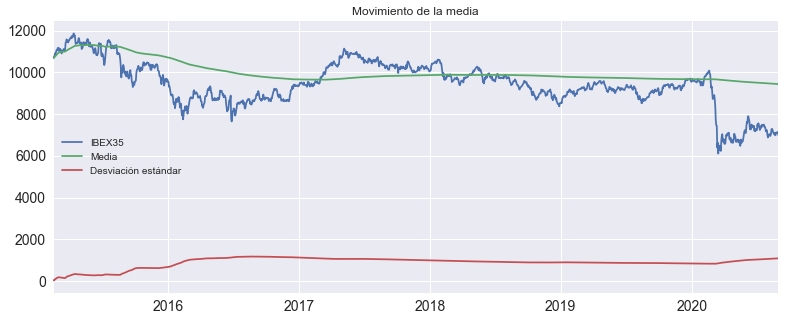

In [16]:
# Función para calcular los movimientos de la media
def mean_movement(data, window):
    # Obtenemos la media y desviación estándar de los datos
    data_mean = data_total.rolling(window, min_periods=1).mean()
    data_std = data_total.rolling(window, min_periods=1).std()
    # Pintamos la gráfica
    plt.rcParams["figure.figsize"] = (16,8)
    data_total.ultimo.plot(figsize=(13,5), label='IBEX35', fontsize=14)
    data_mean.ultimo.plot(figsize=(13,5), label='Media', fontsize=14)
    data_std.ultimo.plot(figsize=(13,5), label='Desviación estándar', fontsize=14)
    plt.legend(loc='best')
    plt.title('Movimiento de la media')
    plt.show()

mean_movement(data_total, 2000)

Analizando a simple vista esta serie podemos observar que existe una tendencia a decrecer a largo plazo, se trata de una serie Heterocedástica ya que la variabilidad de la serie aumenta y disminuye a lo largo del tiempo y no se trata de datos cíclicos ya que no existe un patrón.
Esta tendencia al alza ya nos indica que nuestros datos no son estacionarios, ya que la media y la desviación típica varían año a año al alza.

### Test de Dickey-Fuller
Aunque ya en la gráfica anterior podíamos ver que nuestros datos no son estacionarios para asegurarnos al 100% podemos realizar algún test de estacionalidad. Este test básicamente lo que hace es eliminar las autocorrelaciones de los datos y probar si son estacionarios.

In [17]:
# Función para calcular el test de Dickey-Fuller
def stationary_dickeyfuller_test(data):
    print("Resultados del test de Dickey-Fuller aumentada (ADF):")
    df_test = adfuller(data, autolag='AIC')
    df_results = pd.Series(df_test[:4], index=['Test Statistic', 'P-Value', 'Lags used', 'Number of observations used'])
    return df_results

# Llamamos a la función para obtener los resultados de la función de Dickey-Fuller
stationary_dickeyfuller_test(data_total.ultimo)

Resultados del test de Dickey-Fuller aumentada (ADF):


Test Statistic                   -1.717212
P-Value                           0.422267
Lags used                         2.000000
Number of observations used    1444.000000
dtype: float64

En este caso la hipótesis nula es que nuestros datos son estacionarios, para eso se tiene que dar que el P-valor sea menor de 0.05 y que el Test estadístico sea lo más negativo posible. En nuestro caso se cumple ambas condiciones con lo que podemos confirmar que no se cumple la hipótesis nula y por tanto nuestros datos NO son estacionarios.

### Seasonal decompose
Por último vamos a realizar una descomposición de los datos para evaluar los distintos elementos de una serie temporal por separado:
- Tendencia: el aumento o disminución a largo plazo de los datos.
- Estacional o periódico: si la serie está influenciada por factores estacionales; esta siempre existe en una serie.
- Cíclico: si existen subidas y bajadas que no son del periodo fijo; se denomina patrón cíclico.
Analizar estas gráficas nos proporciona información esencial para decidir que módelos aplicar o con qué parámetros.


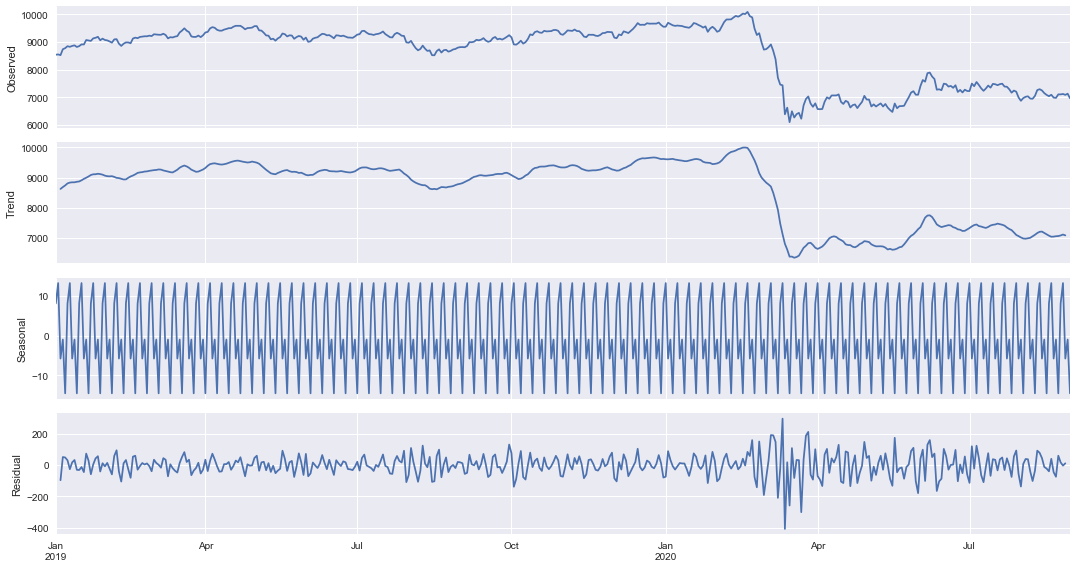

In [18]:
# En nuestro caso como el periodo es B (business day frequency) de Lúnes a Viernes, el valor freq esperado es de 5
res = sm.tsa.seasonal_decompose(data_total.ultimo.truncate(before = "2019").dropna(), freq=5)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

- 1º gráfica: nos muestra los datos observados con un pequeño suavizado.
- 2º gráfica: nos muestra la tendencia. En este gráfico como la visualización sólo nos muestra desde el año 2019 no se aprecia pero la tendencia a la largo plazo en este caso es ascendente
- 3º gráfica: nos aisla el patrón y podemos ver como el patrón se repite constantemente.
- 4º gráfica: los residuos que se muestran aleatorios y con una media constante.

### Aplicar transformación a los datos para conseguir estacionariedad
Como vimos anteriormente en el test de Dickey-Fuller no se cumple la hipótesis nula y por tanto nuestros datos NO son estacionarios. Para conseguir estacionariedad vamos a utilizar la diferencia de una serie consigo misma tras desplazarla 1 lag. 
Los datos dependen mucho entre si y no se trata de una serie estacionaria para ello vamos a utilizar la diferencia de una serie consigo mismo tras desplazarla 1 lag.

In [19]:
data_total_diff = data_total.ultimo - data_total.ultimo.shift(1)
data_total_diff.dropna(inplace = True)
data_total_diff.head()

2015-02-16    -50.0
2015-02-17      8.5
2015-02-18    107.3
2015-02-19    105.1
2015-02-20    -31.1
Freq: B, Name: ultimo, dtype: float64

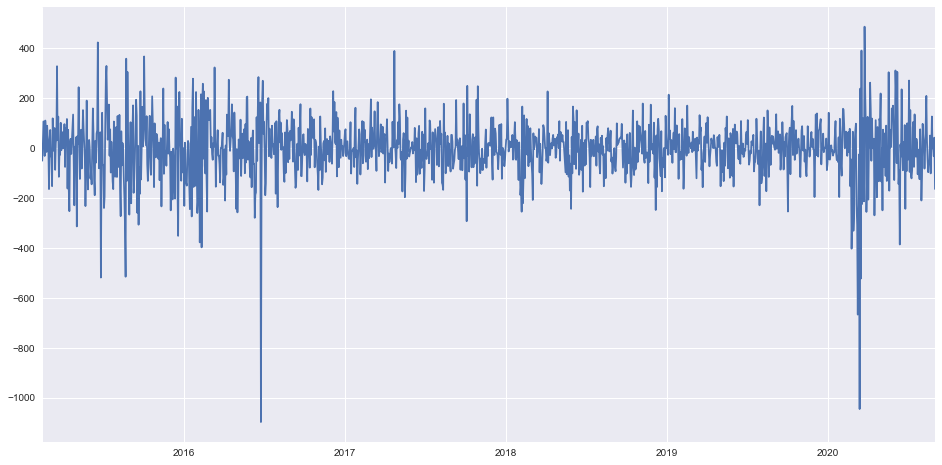

In [20]:
plt.rcParams["figure.figsize"] = (16,8)
data_total_diff.plot()
plt.show()

Comprobamos que calculando la diferencia de una serie consigo misma tras desplazarla un lag mejoramos su estacionariedad. Esta visualización sugiere que la estacionaridad y tendencia han sido eliminados por la diferenciación 

### Autocorrelación simple y autocorrelación parcial
La configuración del modelo ARIMA, depende del tipo de serie temporal que queremos predecir. Alguna de las características que hay que tener en cuenta son la autocorrelación y la autocorrelación parcial de los datos. A partir de sus gráficas podremos ajustar mejor los parámetros del modelo.
Para poder analizar la serie es necesario identificar la estructura que la genera, es decir cómo influyen las observaciones del pasado en las observaciones del futuro. Esta dependencia se puede identificar utilizando dos fuentes de información:

- Función de Autocorrelación simple (FAS): proporciona la estructura de dependencia lineal de la misma. La idea de la función es proporcionar un coeficiente de correlación entre las observaciones separadas un número determinado de periodos.
- Función de Autocorrelación parcial (FAP): proporciona la relación directa que existe entre observaciones separadas por k retardos cuando no se considera la dependencia creada por los retardos intermedios existentes entre ambas.

La función ACF es usada para identificar el proceso de media móvil (MA) en un modelo ARIMA; mientras que la función PACF se usa para identificar los valores de la parte del proceso autoregresivo (AR).

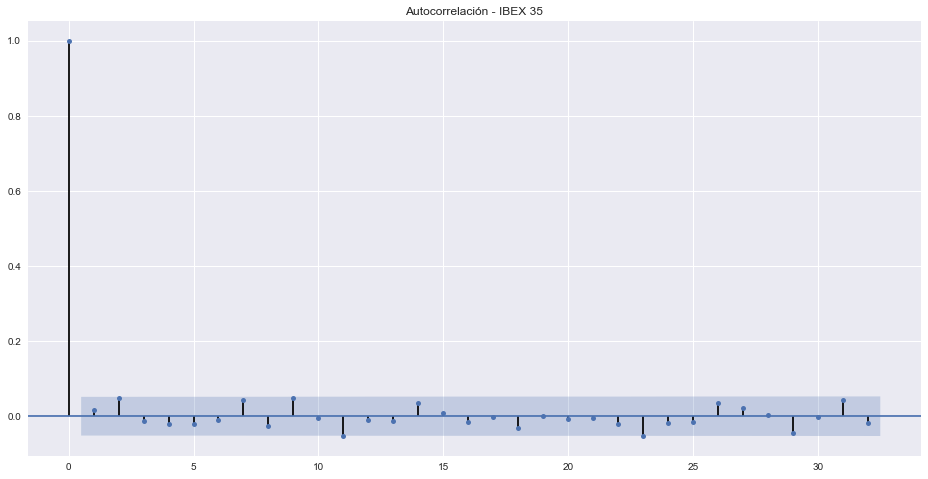

In [21]:
# FAS: Función de autocorrelación simple
acf = plot_acf(data_total_diff, unbiased=True)
plt.title('Autocorrelación - IBEX 35')
plt.show()

Como se puede observar la función de autocorrelación proporciona los coeficientes de correlación de la serie consigo misma para distintos retardos. En este caso los coeficientes son significativos para los retardos 2, 11 y 23; esto es así, porque los límites para considerar significativo un retardo son todos aquellos coeficientes que se encuentren fuera de la sombra azul. Esto indica que una observación influye bastante sobre las que están muy alejadas de ella.

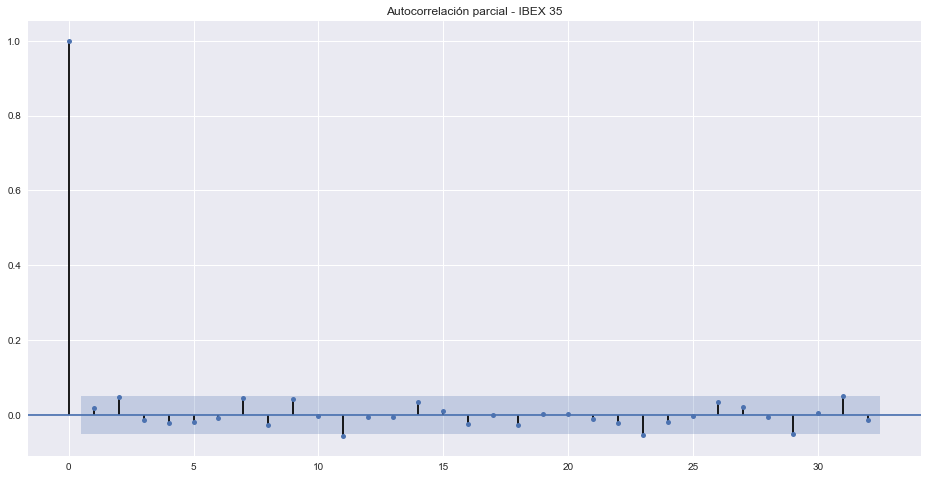

In [22]:
# FAP: Función de autocorrelación parcial
pacf = plot_pacf(data_total_diff)
plt.title('Autocorrelación parcial - IBEX 35')
plt.show()

Aquí podemos observar que segundo (entre otros) retardo son significativos, mientras que el resto no lo es.

Analizando ambas gráficas podemos indicar que el coeficiente de correlación muestral es significativo porque sobrepasa el límite de la prueba de hipótesis en la FAS y FAP por lo tanto existe autocorrelación. 
También podemos observar examinando ambas gráficos que NO posee componentes estacionales.

Tras este análisis, podemos justificar que el modelo que se deberá utilizar es ARIMA(p,d,q); cuyo valor como parámetro d será igual 1. Para el resto de parámetros se obtendrán con el método AIC.

## Ajuste de un modelo ARIMA(p,d,q)

En nuestro caso la serie no es estacionaria, debemos aplicar un modelo ARIMA(p,d,q). Donde p denota el número de términos autoregresivos, d el número de veces que la serie debe ser diferenciada para hacerla estacionaria y q el número de términos de la media móvil invertible.
De los análisis anteriores podemos establecer los siguientes parámetros:
- p; gráfico función de autocorrelación parcial
- d=1; número de diferenciaciones necesarias para conseguir que la serie sea estacionaria
- q; gráfico función de autocorrelación simple

El modelo ARIMA es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

### 01. Entrenamiento modelo ARIMA(p,1,q) y representación de los resultados para los predictores deuda_publica, ipc, tasa_paro, pib y el resto de métricas para los 10 primeros componentes que componen el IBEX 35

Será necesario rellenar los valores núlos de las variables exogenous; para ello vamos a utilizar el método "forward fill" (los valores no nulos se copian hacia adelante siempre que se encuentren valores nulos).

In [23]:
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos.
data_total.fillna(method='ffill', inplace=True)

In [24]:
data_total

,ultimo,deuda_publica,ipc,tasa_paro,pib,AENA_ultimo,AENA_per,AENA_bpa,AENA_rentabilidad_por_dividendo,AENA_precio_valor_contable,...,SAN_per,SAN_bpa,SAN_rentabilidad_por_dividendo,SAN_precio_valor_contable,TEF_ultimo,TEF_per,TEF_bpa,TEF_rentabilidad_por_dividendo,TEF_precio_valor_contable,TEF_ebitda
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15,74.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,12.934,0.00,0.00,0.00,0.00,0.0
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15,72.50,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,12.900,0.00,0.00,0.00,0.00,0.0
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15,74.90,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,12.890,0.00,0.00,0.00,0.00,0.0
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15,76.87,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,12.905,0.00,0.00,0.00,0.00,0.0
2015-02-19,10910.4,1044720.44,-1.07,23.78,1.15,77.15,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,13.023,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-25,7108.4,1257818.96,-0.60,15.33,-18.50,122.50,12.34,-0.31,0.0,2.94,...,9.62,0.19,5.28,0.33,3.515,8.29,0.42,11.38,1.01,14615.0
2020-08-26,7123.0,1257818.96,-0.60,15.33,-18.50,124.20,12.34,-0.31,0.0,2.94,...,9.62,0.19,5.21,0.33,3.468,8.29,0.42,11.53,1.01,14615.0
2020-08-27,7090.7,1257818.96,-0.60,15.33,-18.50,124.20,12.34,-0.31,0.0,2.94,...,9.62,0.19,5.26,0.33,3.435,8.29,0.42,11.64,1.01,14615.0
2020-08-28,7133.0,1257818.96,-0.60,15.33,-18.50,128.80,12.34,-0.31,0.0,2.94,...,9.62,0.19,5.10,0.33,3.390,8.29,0.42,11.80,1.01,14615.0


In [25]:
# Definimos los datos de train y test
train_with_predict = data_total[0:1427]
test_with_predict = data_total[1427:]

El siguiente paso será estimar los parámetros p y q para el modelo ARIMA(). Para escoger cuál de los distintas opciones vamos a escoger nos vamos a basar en el crítero AIC.
- Criterio BIC: trata de seleccionar el modelo correcto, con máxima probabilidad a posteriori, y puede demostrarse que es un criterio consistente de manera que la probabilidad de seleccionar el modelo correcto tiende a 1 cuando aumenta el tamaño muestral. Asume que el modelo real está incluido en el conjunto de modelos candidatos, y mide el grado de certeza de que un cierto modelo sea el verdadero modelo generador de los datos.
- Critero AIC: no pretende seleccionar el modelo correcto, ya que admite que el modelo verdadero puede no estar entre los estimados tratando de obtener el modelo que proporcione mejores predicciones entre los existentes. No asume que ninguno de los modelos candidatos sea necesariamente el verdadero, calculando para cada modelo la información o discrepancia de Kullback-Leibler, que es una medida de la distancia entre la densidad de probabilidad generada por el modelo y la realidad.

In [26]:
p = q = range(0,4)
pdq = [(x[0], 1, x[1]) for x in list (itertools.product(p,q))]
res_parameters_with_predict = []
for param in pdq:
    try:
        mod=SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=param,
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False)
        results = mod.fit()
        res_parameters_with_predict.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic_with_predict = pd.DataFrame(res_parameters_with_predict)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.aic == res_aic_bic_with_predict.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.bic == res_aic_bic_with_predict.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

Parámetros p y q que minimizan la paramétrica AIC:
       param           aic           bic
4  (1, 1, 0)  17062.472241  17394.017843

Parámetros p y q que minimizan la paramétrica BIC:
       param           aic           bic
4  (1, 1, 0)  17062.472241  17394.017843


Entrenamos el modelo ARIMA(1,1,0) con nuestras variables exogenous.

In [27]:
# Segundo modelo de Series temporales > ARIMA(1,1,0)
train_with_predict = train_with_predict.to_timestamp()

model01_st_arima110 = SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=(1,1,0),
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [28]:
model01_st_arima110.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2059: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 ultimo   No. Observations:                 1427
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -8468.236
Date:                Sun, 06 Sep 2020   AIC                          17062.472
Time:                        19:17:17   BIC                          17394.018
Sample:                    02-13-2015   HQIC                         17186.298
                         - 08-03-2020                                         
Covariance Type:                  opg                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
deuda_publica                      -0.0004   2.16e-34  -1.63e+30      0.000      -0.000      -0.000
ipc                                -0.6663         -0        inf      0.000      -0.666      -0.666
tasa_paro                          -0.6759   8.64e-39  -7.82e+37      0.000      -0.676      -0.676
pib                                 0.0105   1.41e-38   7.44e+35      0.000       0.011       0.011
AENA_ultimo                        30.0758    1.3e-31   2.32e+32      0.000      30.076      30.076
AENA_per                            0.0380   7.44e-29   5.11e+26      0.000       0.038       0.038
AENA_bpa                            0.0816   1.67e-32   4.89e+30      0.000       0.082       0.082
AENA_rentabilidad_por_dividendo    -0.0741   4.94e-41   -1.5e+39      0.000      -0.074      -0.074
AENA_precio_valor_contable         -0.1752   3.89e-32  -4.51e+30      0.000      -0.175      -0.175
AENA_ebitda                        -0.2018   1.99e-29  -1.02e+28      0.000      -0.202      -0.202
AMS_ultimo                          6.3094   2.08e-31   3.04e+31      0.000       6.309       6.309
AMS_per                            -0.0671   4.66e-28  -1.44e+26      0.000      -0.067      -0.067
AMS_bpa                             0.0339    5.9e-32   5.75e+29      0.000       0.034       0.034
AMS_rentabilidad_por_dividendo     -0.1073   4.49e-31  -2.39e+29      0.000      -0.107      -0.107
AMS_precio_valor_contable          -0.0109   2.84e-32  -3.85e+29      0.000      -0.011      -0.011
AMS_ebitda                          0.1420   4.34e-29   3.27e+27      0.000       0.142       0.142
BBVA_ultimo                         0.6142   2.51e-32   2.44e+31      0.000       0.614       0.614
BBVA_per                            0.0183   2.45e-31   7.45e+28      0.000       0.018       0.018
BBVA_bpa                            0.0005   1.16e-33   3.92e+29      0.000       0.000       0.000
BBVA_rentabilidad_por_dividendo    -0.2546   8.55e-32  -2.98e+30      0.000      -0.255      -0.255
BBVA_precio_valor_contable         -0.0003   1.25e-32  -2.72e+28      0.000      -0.000      -0.000
CABK_ultimo                         0.2959   3.43e-34   8.62e+32      0.000       0.296       0.296
CABK_per                            0.0816    9.3e-31   8.78e+28      0.000       0.082       0.082
CABK_bpa                           -0.0011   2.97e-42  -3.59e+38      0.000      -0.001      -0.001
CABK_rentabilidad_por_dividendo    -0.1118    6.7e-32  -1.67e+30      0.000      -0.112      -0.112
CABK_precio_valor_contable         -0.0001   2.13e-32  -4.74e+27      0.000      -0.000      -0.000
FER_ultimo                          2.2874   8.59e-32   2.66e+31      0.000       2.287       2.287
FER_per                            -0.3540   3.61e-29   -9.8e+27      0.000      -0.354      -0.354
FER_bpa                             0.0025   5.38e-32   4.64e+28      0.000       0.002       0.002
FER_rentabilidad_por_dividendo     -0.026

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. En este caso todas tienen un valor de p-value inferior a 0.5 pudiendo rechazar la hipótesis nula.

A continuación vamos a predecir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

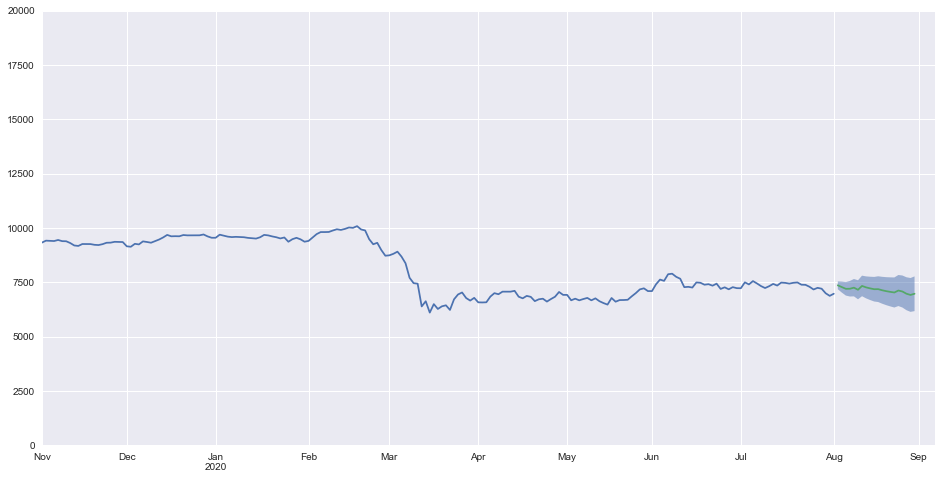

In [29]:
y_pred_with_predict = model01_st_arima110.get_forecast(20, 
                                                       exog=train_with_predict.iloc[train_with_predict.shape[0]-20:,-61:])

lower_with_predict = y_pred_with_predict.conf_int()["lower ultimo"]
upper_with_predict = y_pred_with_predict.conf_int()["upper ultimo"]
train_with_predict.ultimo.truncate(before = "2019").plot()

y_pred_with_predict.predicted_mean.plot()
plt.fill_between(lower_with_predict.index, lower_with_predict, upper_with_predict, alpha=0.5)
plt.axis(['2019-11-01','2020-09-05',0,20000])
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [31]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train_with_predict.ultimo, model01_st_arima110.fittedvalues))

- TRAIN -
Mean squared error: 59244.29


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn.
TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [53]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train_with_predict):
    X_tr, X_val = train_with_predict.iloc[train_index, :], train_with_predict.iloc[test_index, :]
    y_tr, y_val = train_with_predict.iloc[train_index], train_with_predict.iloc[test_index]
    model = SARIMAX(X_tr.iloc[:, 0], 
                         exog=X_tr.iloc[:,1:], 
                         order=(1,1,0),
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

- TRAIN -
Cross-Validation > Mean squared error: 520.51


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [34]:
path_model_save = "./models/arima110_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib+other_components.pkl"  
joblib.dump(model01_st_arima110, path_model_save)

['./models/arima110_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib+other_components.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [35]:
model01_st_arima210 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19 

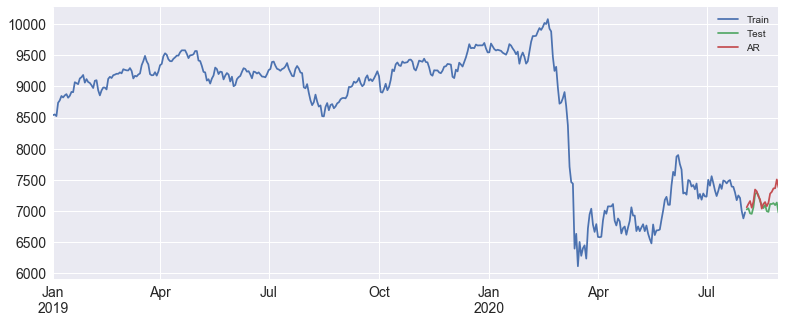

In [36]:
# Primer modelo de Series temporales > AR (Modelo autorregresivo)
y_pred_test_with_predict2 = test_with_predict.to_timestamp()
y_pred_test_with_predict = y_pred_test_with_predict2.copy()
y_pred_test_with_predict['AR'] = model01_st_arima110.predict(n_periods=len(y_pred_test_with_predict2), 
                                                             start=y_pred_test_with_predict2.index.min(), 
                                                             end=y_pred_test_with_predict2.index.max(),
                                                             exog=test_with_predict.iloc[:,-61:]
                                                             ,
                                                             dynamic=False
                                                            )
y_pred_test_with_predict

plt.figure(figsize=(16,8))
train_with_predict.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test_with_predict.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test_with_predict.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [37]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test_with_predict.ultimo, 
                                                              y_pred_test_with_predict['AR']))

- TEST -
Mean squared error: 30354.90


El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

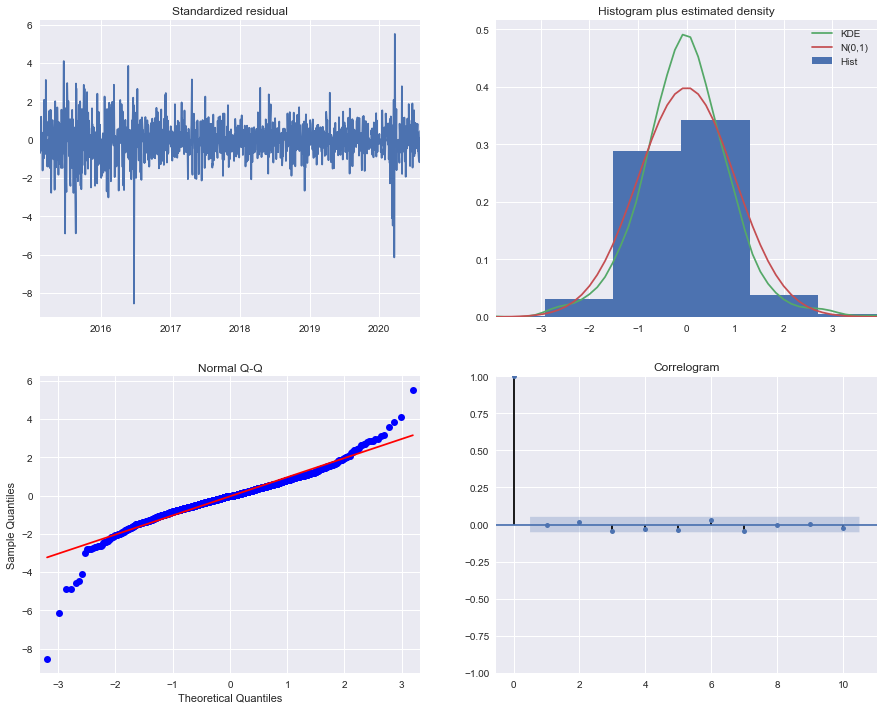

In [38]:
model01_st_arima110.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.


Ploteamos los residuos
Podemos observar en las gráficas que existe poca autocorrelación.

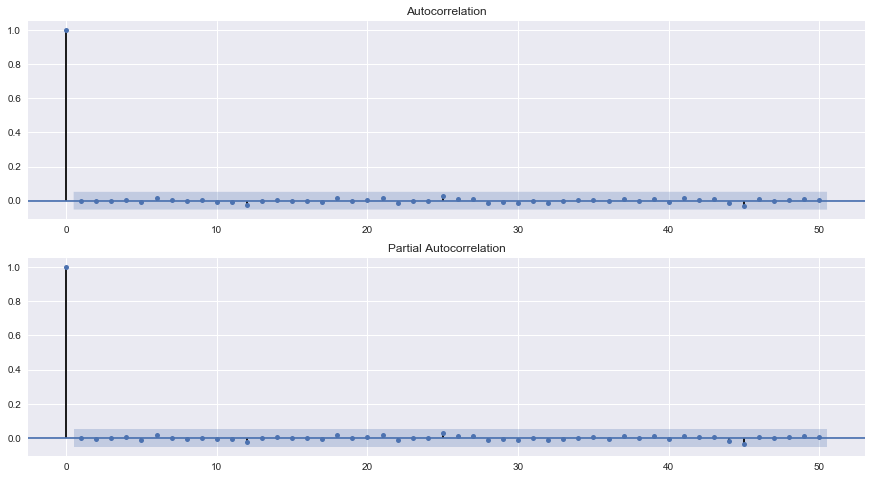

In [39]:
res = model01_st_arima110.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

## Ajuste de un modelo SARIMA(p,d,q)x(P,D,Q)s

Este modelo (Seasonal autoregressive integrated moving average) captura la particularidad estacional y cíclica de nuestra serie de interés (la parte cíclica es la asociada al componente autorregresivo y de media móvil).
Serie temporal estacional dónde:
    - (p,d,q) se trata de la parte o retardos regulares 
    - (P,D,Q)s se trata de la parte estacional y s es el número de observaciones por año
    
Los modelos SARIMA tienen los momentos y correlogramas iguales que los ARIMA pero en vez de considerar los retardos regulares nos fijaremos en los retardos estacionales.

Aunque no podemos observar un patrón sistemático que se repite periódicamente de forma clara, vamos a probar ya que en los datos económicas es muy frecuente tener una fuerte componente estacional y no estacionarios.

En este dataset como el periodo es B (business day frequency) de Lúnes a Viernes el valor para s sería de 52 (número de observaciones por año).

### 02. Entrenamiento modelo SARIMA(1,1,0)(P,D,Q,52) y representación de los resultados para los predictores deuda_publica, ipc, tasa_paro, pib y otras métricas de los 10 componentes más importantes que forman parte del IBEX 35

El siguiente paso será estimar los parámetros P, D y Q para el modelo SARIMA(). Para escoger cuál de los distintas opciones vamos a escoger nos vamos a basar en el crítero AIC.
- Criterio BIC: trata de seleccionar el modelo correcto, con máxima probabilidad a posteriori, y puede demostrarse que es un criterio consistente de manera que la probabilidad de seleccionar el modelo correcto tiende a 1 cuando aumenta el tamaño muestral. Asume que el modelo real está incluido en el conjunto de modelos candidatos, y mide el grado de certeza de que un cierto modelo sea el verdadero modelo generador de los datos.
- Critero AIC: no pretende seleccionar el modelo correcto, ya que admite que el modelo verdadero puede no estar entre los estimados tratando de obtener el modelo que proporcione mejores predicciones entre los existentes. No asume que ninguno de los modelos candidatos sea necesariamente el verdadero, calculando para cada modelo la información o discrepancia de Kullback-Leibler, que es una medida de la distancia entre la densidad de probabilidad generada por el modelo y la realidad.

In [40]:
p = d = q = range(0,2)
pdq = [(x[0], x[1], x[2], 52) for x in list (itertools.product(p,d,q))]
res_parameters_with_predict = []
for param in pdq:
    try:
        mod=SARIMAX(train_with_predict.iloc[:, 0],
                    exog=train_with_predict.iloc[:,1:],
                    order=(1,1,0),
                    seasonal_order=param,
                    freq='B',
                    enforce_stationary=False,
                    enforce_invertibility=False)
        results = mod.fit()
        res_parameters_with_predict.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic_with_predict = pd.DataFrame(res_parameters_with_predict)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.aic == res_aic_bic_with_predict.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.bic == res_aic_bic_with_predict.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

Parámetros p y q que minimizan la paramétrica AIC:
           param           aic           bic
3  (0, 1, 1, 52)  16548.556324  16882.987138

Parámetros p y q que minimizan la paramétrica BIC:
           param           aic           bic
3  (0, 1, 1, 52)  16548.556324  16882.987138


Entrenamos el modelo SARIMA(1,1,0)(0,1,1,52) con nuestras variables exogenas.

In [42]:
# Segundo modelo de Series temporales > SARIMA(1,1,0)(0,1,1,52)
#train_with_predict = train_with_predict.to_timestamp()
model01_st_sarima110011 = SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=(1,1,0),
                         seasonal_order=(0,1,1,52),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
model01_st_sarima110011.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2059: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             ultimo   No. Observations:                 1427
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 52)   Log Likelihood               -8210.278
Date:                            Sun, 06 Sep 2020   AIC                          16548.556
Time:                                    20:20:40   BIC                          16882.987
Sample:                                02-13-2015   HQIC                         16673.691
                                     - 08-03-2020                                         
Covariance Type:                              opg                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
deuda_publica                       0.0002   6.89e-29   3.06e+24      0.000       0.000       0.000
ipc                                 1.6872         -0       -inf      0.000       1.687       1.687
tasa_paro                           2.8677   1.08e-34   2.66e+34      0.000       2.868       2.868
pib                                 1.3903   1.55e-33      9e+32      0.000       1.390       1.390
AENA_ultimo                        18.0197   1.23e-30   1.47e+31      0.000      18.020      18.020
AENA_per                           -0.2301   8.45e-29  -2.72e+27      0.000      -0.230      -0.230
AENA_bpa                           -0.3710   6.12e-32  -6.06e+30      0.000      -0.371      -0.371
AENA_rentabilidad_por_dividendo    -1.8985   4.39e-32  -4.32e+31      0.000      -1.899      -1.899
AENA_precio_valor_contable          0.1651   6.93e-32   2.38e+30      0.000       0.165       0.165
AENA_ebitda                        -0.1594      3e-29  -5.32e+27      0.000      -0.159      -0.159
AMS_ultimo                         59.7383   8.15e-33   7.33e+33      0.000      59.738      59.738
AMS_per                             0.0166   4.06e-28    4.1e+25      0.000       0.017       0.017
AMS_bpa                            -1.1399   2.45e-32  -4.65e+31      0.000      -1.140      -1.140
AMS_rentabilidad_por_dividendo      1.8691   2.49e-31   7.51e+30      0.000       1.869       1.869
AMS_precio_valor_contable           0.1090   1.62e-31   6.71e+29      0.000       0.109       0.109
AMS_ebitda                          0.2450   1.21e-29   2.03e+28      0.000       0.245       0.245
BBVA_ultimo                         2.7283   6.94e-33   3.93e+32      0.000       2.728       2.728
BBVA_per                            0.3242   6.29e-31   5.15e+29      0.000       0.324       0.324
BBVA_bpa                           -0.0087   5.57e-33  -1.57e+30      0.000      -0.009      -0.009
BBVA_rentabilidad_por_dividendo    -1.1680    1.7e-31  -6.87e+30      0.000      -1.168      -1.168
BBVA_precio_valor_contable          0.0007   3.27e-32    2.1e+28      0.000       0.001       0.001
CABK_ultimo                         1.2264   1.75e-32   7.01e+31      0.000       1.226       1.226
CABK_per                            0.3716   1.17e-30   3.19e+29      0.000       0.372       0.372
CABK_bpa                           -0.0115   1.18e-33  -9.79e+30      0.000      -0.012      -0.012
CABK_rentabilidad_por_dividendo    -0.6482   2.07e-32  -3.13e+31      0.000      -0.648      -0.648
CABK_precio_valor_contable          0.0018   3.24e-32   5.57e+28      0.000       0.002       0.002
FER_ultimo                          9.2491   1.52e-32   6.08e+32      0.000       9.249       9.249
FER_per                            -0.4174   2.18e-29  -1.91e+28      0.000      -0.417      -0.417
FER_bpa                          

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. En este caso todas las variables tienen un valor de p-value inferior a 0.5 por lo que podemos rechazar la hipótesis nula.

A continuación vamos a predicir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

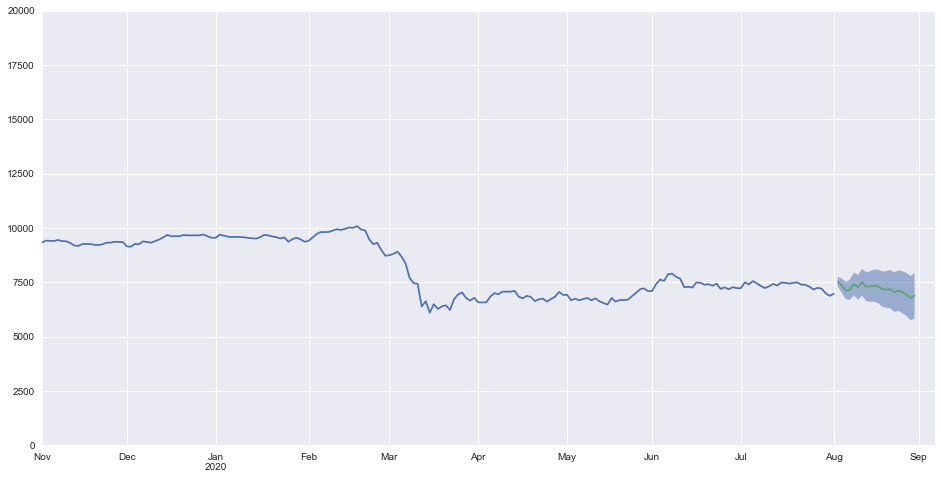

In [45]:
y_pred_with_predict = model01_st_sarima110011.get_forecast(20, 
                                                       exog=train_with_predict.iloc[train_with_predict.shape[0]-20:,-61:])

lower_with_predict = y_pred_with_predict.conf_int()["lower ultimo"]
upper_with_predict = y_pred_with_predict.conf_int()["upper ultimo"]
train_with_predict.ultimo.truncate(before = "2019").plot()

y_pred_with_predict.predicted_mean.plot()
plt.fill_between(lower_with_predict.index, lower_with_predict, upper_with_predict, alpha=0.5)
plt.axis(['2019-11-01','2020-09-05',0,20000])
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [46]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train_with_predict.ultimo, model01_st_sarima110011.fittedvalues))

- TRAIN -
Mean squared error: 42116.66


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn. TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [56]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train_with_predict):
    X_tr, X_val = train_with_predict.iloc[train_index, :], train_with_predict.iloc[test_index, :]
    y_tr, y_val = train_with_predict.iloc[train_index], train_with_predict.iloc[test_index]
    model = SARIMAX(X_tr.iloc[:, 0], 
                         exog=X_tr.iloc[:,1:], 
                         order=(1,1,0),
                         seasonal_order=(0,1,1,52),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- TRAIN -
Cross-Validation > Mean squared error: 967.20


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [51]:
path_model_save = "./models/sarima110011_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib+other_components.pkl"  
joblib.dump(model01_st_sarima110011, path_model_save)

['./models/sarima110011_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib+other_components.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [52]:
model01_st_sarima110011 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19

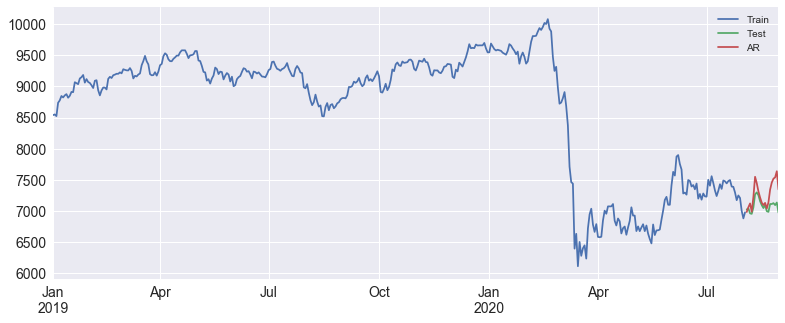

In [47]:
# Segundo modelo de Series temporales > SARIMA(1,1,0)(0,1,1,52)
y_pred_test_with_predict2 = test_with_predict.to_timestamp()
y_pred_test_with_predict = y_pred_test_with_predict2.copy()
y_pred_test_with_predict['AR'] = model01_st_sarima110011.predict(n_periods=len(y_pred_test_with_predict2), 
                                                             start=y_pred_test_with_predict2.index.min(), 
                                                             end=y_pred_test_with_predict2.index.max(),
                                                             exog=test_with_predict.iloc[:,-61:],
                                                             dynamic=False)
y_pred_test_with_predict

plt.figure(figsize=(16,8))
train_with_predict.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test_with_predict.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test_with_predict.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [48]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test_with_predict.ultimo, 
                                                              y_pred_test_with_predict.AR))

- TEST -
Mean squared error: 55979.35


El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

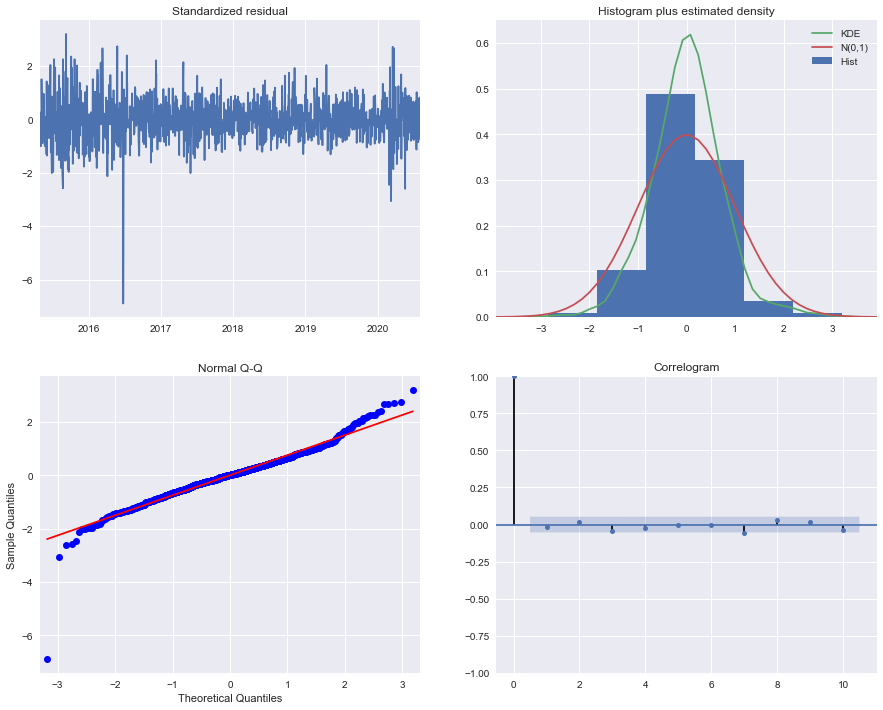

In [49]:
model01_st_sarima110011.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal aunque aún la curva verde no se aproxima a la forma gaussiana de la roja.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.


Ploteamos los residuos
Podemos observar en las gráficas que existe poca autocorrelación.

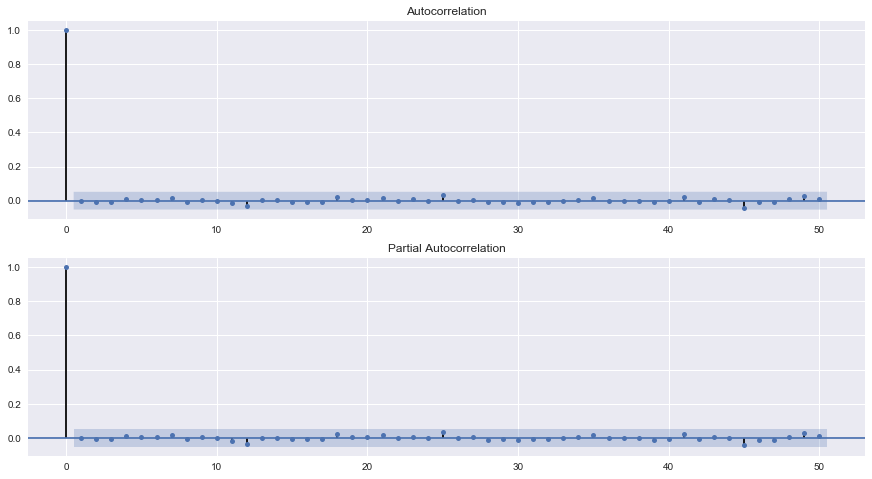

In [50]:
res = model01_st_sarima110011.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()